**Разработка интеллектуальной системы планирования ремонта автомобилей таксопарка**


Импорт библиотек

In [705]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn.multioutput import ClassifierChain
from sklearn.neighbors import KNeighborsClassifier

Импорт данных

In [706]:
df_service_records = pd.read_csv('data/Vehicle Maintenance- Service Records.csv', sep=",")
print(df_service_records.shape)
df_service_records.head()

(1139, 24)


,slno,vehicle_type,brand,model,engine_type,make_year,region,mileage_range,mileage,oil_filter,...,air_clean_filter,fuel_filter,spark_plug,brake_fluid,brake_and_clutch_oil,transmission_fluid,brake_pads,clutch,coolant,cost
0,1,car,honda,jazz,petrol,2017,chennai,10000,11400,1,...,0,0,0,0,0,0,0,0,0,2566
1,2,car,honda,jazz,petrol,2017,chennai,10000,11453,1,...,0,0,0,0,0,0,0,0,0,2633
2,3,car,honda,jazz,petrol,2017,chennai,10000,10706,1,...,0,0,0,0,0,0,0,0,0,2643
3,4,car,honda,jazz,petrol,2017,chennai,10000,11015,1,...,0,0,0,0,0,0,0,0,0,2532
4,5,car,honda,jazz,petrol,2017,chennai,10000,10039,1,...,0,0,0,0,0,0,0,0,0,2489


Удалим пустые строки и дубликаты, выведем информацию о данных в формате:
колонка - количесвто экземпляров - тип данных;
и выведем информацию об использовании памяти

In [707]:
df_service_records = df_service_records.dropna().drop_duplicates()
df_service_records.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1139 entries, 0 to 1138
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   slno                           1139 non-null   int64 
 1   vehicle_type                   1139 non-null   object
 2   brand                          1139 non-null   object
 3   model                          1139 non-null   object
 4   engine_type                    1139 non-null   object
 5   make_year                      1139 non-null   int64 
 6   region                         1139 non-null   object
 7   mileage_range                  1139 non-null   int64 
 8   mileage                        1139 non-null   int64 
 9   oil_filter                     1139 non-null   int64 
 10  engine_oil                     1139 non-null   int64 
 11  washer_plug_drain              1139 non-null   int64 
 12  dust_and_pollen_filter         1139 non-null   int64 
 13  whe

Проверка на пропуски

In [708]:
df_service_records.isnull().sum()

slno                             0
vehicle_type                     0
brand                            0
model                            0
engine_type                      0
make_year                        0
region                           0
mileage_range                    0
mileage                          0
oil_filter                       0
engine_oil                       0
washer_plug_drain                0
dust_and_pollen_filter           0
whell_alignment_and_balancing    0
air_clean_filter                 0
fuel_filter                      0
spark_plug                       0
brake_fluid                      0
brake_and_clutch_oil             0
transmission_fluid               0
brake_pads                       0
clutch                           0
coolant                          0
cost                             0
dtype: int64

Посмотрим, на количесвто уникальных значений в колонках

In [709]:
df_service_records.nunique()

slno                             1139
vehicle_type                        1
brand                               2
model                               4
engine_type                         2
make_year                           3
region                              2
mileage_range                       9
mileage                           754
oil_filter                          1
engine_oil                          1
washer_plug_drain                   2
dust_and_pollen_filter              2
whell_alignment_and_balancing       2
air_clean_filter                    2
fuel_filter                         2
spark_plug                          2
brake_fluid                         2
brake_and_clutch_oil                2
transmission_fluid                  2
brake_pads                          2
clutch                              2
coolant                             2
cost                              688
dtype: int64

Удалим колонки с единственным ункальным значением

In [710]:
unique_counts = df_service_records.nunique()
cols_to_drop = unique_counts[unique_counts == 1].index
df_service_records.drop(cols_to_drop, axis=1, inplace=True)
print(df_service_records.shape)
df_service_records.head()

(1139, 21)


,slno,brand,model,engine_type,make_year,region,mileage_range,mileage,washer_plug_drain,dust_and_pollen_filter,...,air_clean_filter,fuel_filter,spark_plug,brake_fluid,brake_and_clutch_oil,transmission_fluid,brake_pads,clutch,coolant,cost
0,1,honda,jazz,petrol,2017,chennai,10000,11400,0,0,...,0,0,0,0,0,0,0,0,0,2566
1,2,honda,jazz,petrol,2017,chennai,10000,11453,0,0,...,0,0,0,0,0,0,0,0,0,2633
2,3,honda,jazz,petrol,2017,chennai,10000,10706,0,0,...,0,0,0,0,0,0,0,0,0,2643
3,4,honda,jazz,petrol,2017,chennai,10000,11015,0,0,...,0,0,0,0,0,0,0,0,0,2532
4,5,honda,jazz,petrol,2017,chennai,10000,10039,0,0,...,0,0,0,0,0,0,0,0,0,2489


Колонки brand, model, engine_type, make year, region - характеризуют одну машину, объеденим этои признаки в одну колонку

In [711]:
df_service_records['car_type'] = df_service_records[['brand', 'model', 'engine_type', 'make_year', 'region']].apply(lambda x: ' '.join(x.astype(str)), axis=1)
df_service_records=df_service_records.drop(columns=['brand', 'model', 'engine_type', 'make_year', 'region'])

In [712]:
df_service_records.shape

(1139, 17)

In [713]:
df_service_records.nunique()

slno                             1139
mileage_range                       9
mileage                           754
washer_plug_drain                   2
dust_and_pollen_filter              2
whell_alignment_and_balancing       2
air_clean_filter                    2
fuel_filter                         2
spark_plug                          2
brake_fluid                         2
brake_and_clutch_oil                2
transmission_fluid                  2
brake_pads                          2
clutch                              2
coolant                             2
cost                              688
car_type                            8
dtype: int64

Преобразование категориальных признаков в числовые
LabelEncoder 

In [714]:
le = LabelEncoder()

In [715]:
cat_enc1 = pd.DataFrame({'c1': df_service_records.car_type})
cat_enc1['c1'].unique()
df_service_records.car_type = le.fit_transform(cat_enc1['c1'])
df_service_records.head()

,slno,mileage_range,mileage,washer_plug_drain,dust_and_pollen_filter,whell_alignment_and_balancing,air_clean_filter,fuel_filter,spark_plug,brake_fluid,brake_and_clutch_oil,transmission_fluid,brake_pads,clutch,coolant,cost,car_type
0,1,10000,11400,0,0,1,0,0,0,0,0,0,0,0,0,2566,6
1,2,10000,11453,0,0,1,0,0,0,0,0,0,0,0,0,2633,6
2,3,10000,10706,0,0,0,0,0,0,0,0,0,0,0,0,2643,6
3,4,10000,11015,0,0,0,0,0,0,0,0,0,0,0,0,2532,6
4,5,10000,10039,0,0,0,0,0,0,0,0,0,0,0,0,2489,6


Удалим номер строки и mileage_range (поскольку он отражает значение параметра mileage напрямую)

In [716]:
df_service_records = df_service_records.drop(columns=['slno', 'mileage_range'])

<Axes: >

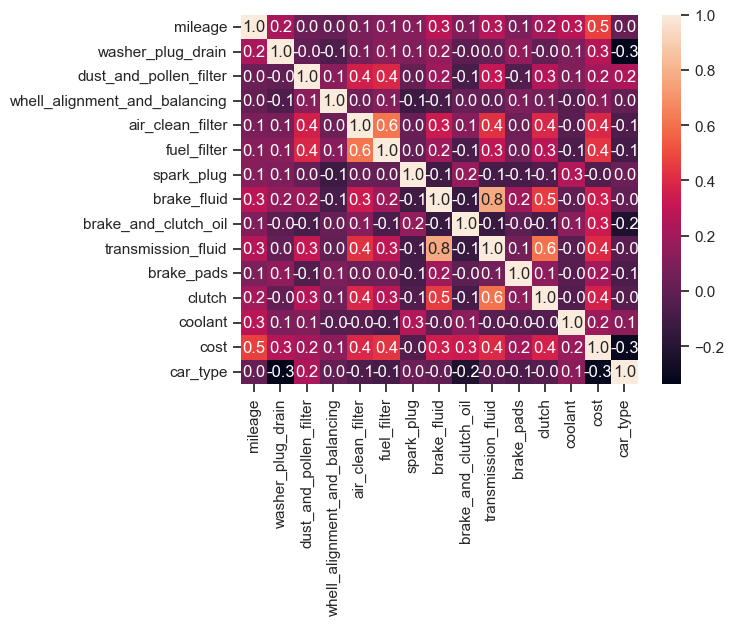

In [717]:
sns.heatmap(df_service_records.corr(), annot=True, fmt='.1f')

<Axes: >

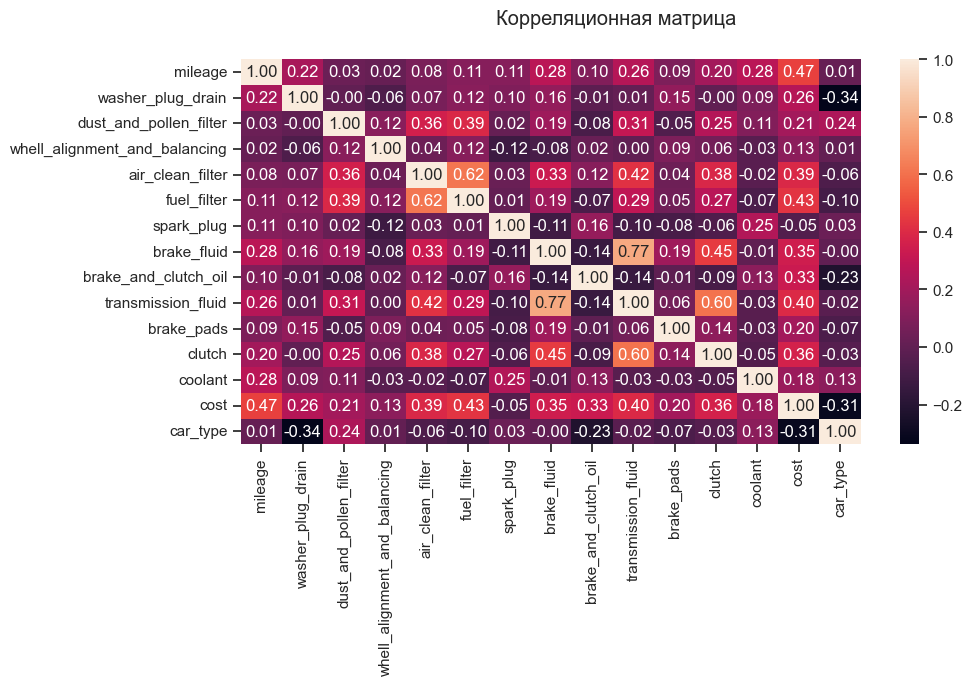

In [718]:
fig, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Корреляционная матрица')
sns.heatmap(df_service_records.corr(),  ax=ax,annot=True, fmt='.2f')

In [719]:
df_service_records = df_service_records.drop(columns=['cost'])

In [720]:
df_X = df_service_records[['car_type', 'mileage']]
df_y = df_service_records.drop(columns=['car_type', 'mileage'])

In [721]:
print(
    f'Входные данные: {df_X.shape[1]} колонок\n'
    f'Выходные данные: {df_y.shape[1]} колонок' 
)

Входные данные: 2 колонок
Выходные данные: 12 колонок


In [722]:
df_X

,car_type,mileage
0,6,11400
1,6,11453
2,6,10706
3,6,11015
4,6,10039
...,...,...
1134,7,96236
1135,7,93438
1136,7,106788
1137,7,112576


In [723]:
df_y

,washer_plug_drain,dust_and_pollen_filter,whell_alignment_and_balancing,air_clean_filter,fuel_filter,spark_plug,brake_fluid,brake_and_clutch_oil,transmission_fluid,brake_pads,clutch,coolant
0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1134,1,1,0,0,1,0,0,0,0,0,0,0
1135,1,1,0,0,1,0,0,0,0,0,0,0
1136,1,0,1,1,1,0,1,0,0,0,0,0
1137,1,0,1,1,1,0,1,0,0,0,0,0


Разбиваем данные на тестовую и обучающую выборку используя случайно, так как неизвестно, распределены ли данные равномерно
Далее при обучении будем применять k-fold кросс-вадидацию

In [724]:
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, shuffle=True)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [725]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3)

Функция для создания многоклассовой классификации с помощью цепочки классификатаров

In [726]:
def make_class_chain(classifier):
    classifier_chain = ClassifierChain(classifier, order='random')
    param_grid_c = {
    'order': [None, 'random'],
    'verbose': [True,False],
            }   
    grid_search = GridSearchCV(classifier_chain, param_grid_c, cv=5,scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_classifier_chain = grid_search.best_estimator_
    best_classifier_chain.fit(X_train, y_train)
    return best_classifier_chain

1 модель K-nn

In [727]:
start_time_knn = time.time()
knn_classifier = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [3,5,7,9],
    'weights': ['uniform','distance'],
    'algorithm': ['auto', 'ball_tree','kd_tree','brute']
            }   
grid_search_knn = GridSearchCV(knn_classifier, param_grid, cv=5, scoring='accuracy')
grid_search_knn.fit(X_train, y_train)
best_knn_model = grid_search_knn.best_estimator_

end_time_knn = time.time()

In [728]:
start_time_knn_2 = time.time()
classifier_chain_knn = make_class_chain(best_knn_model)
end_time_knn_2 = time.time()

[Chain] .................. (1 of 12) Processing order 0, total=   0.0s
[Chain] .................. (2 of 12) Processing order 1, total=   0.0s
[Chain] .................. (3 of 12) Processing order 2, total=   0.0s
[Chain] .................. (4 of 12) Processing order 3, total=   0.0s
[Chain] .................. (5 of 12) Processing order 4, total=   0.0s
[Chain] .................. (6 of 12) Processing order 5, total=   0.0s
[Chain] .................. (7 of 12) Processing order 6, total=   0.0s
[Chain] .................. (8 of 12) Processing order 7, total=   0.0s
[Chain] .................. (9 of 12) Processing order 8, total=   0.0s
[Chain] ................. (10 of 12) Processing order 9, total=   0.0s
[Chain] ................ (11 of 12) Processing order 10, total=   0.0s
[Chain] ................ (12 of 12) Processing order 11, total=   0.0s
[Chain] .................. (1 of 12) Processing order 0, total=   0.0s
[Chain] .................. (2 of 12) Processing order 1, total=   0.0s
[Chain

In [729]:
# Обучаем
start_time_knn_3 = time.time()
classifier_chain_knn.fit(X_train, y_train)
end_time_knn_3 = time.time()

In [730]:
cross_val_scores = cross_val_score(classifier_chain_knn, X_train, y_train, cv=kf)

In [731]:
# Print the cross-validation scores

print(f"Cross-Validation Scores: {cross_val_scores}")
print(f"Mean Cross-Validation Accuracy: {np.mean(cross_val_scores)}")

Cross-Validation Scores: [0.65131579 0.63815789 0.68316832]
Mean Cross-Validation Accuracy: 0.6575473336807365


In [732]:
time_1 = end_time_knn_3-start_time_knn_3 +end_time_knn_2-start_time_knn_2+end_time_knn-end_time_knn

In [733]:
classifier_chain_knn

ClassifierChain(base_estimator=KNeighborsClassifier(n_neighbors=9),
                order='random')

2 модель - Логистическая регрессия 
(на основе градиентного спуска)

In [734]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

In [735]:
# Create a Logistic Regression model
logreg_model = LogisticRegression(max_iter=100)
multi_output_logreg_model = MultiOutputClassifier(logreg_model)
param_grid_lr = {
    'estimator__penalty': ['l2'],
    'estimator__C': np.logspace(-10, 10, 20),
    'estimator__solver': ['liblinear'],
    'estimator__max_iter': [100, 1000, 2500, 5000]
}
grid_search_lr = GridSearchCV(multi_output_logreg_model, param_grid_lr, cv=5, scoring='accuracy', error_score='raise')


In [736]:
start_time_lr = time.time()
grid_search_lr.fit(X_train, y_train)
best_lr_model = grid_search_lr.best_estimator_
end_time_lr = time.time()

In [737]:
time_2=end_time_lr-start_time_lr

In [738]:
best_lr_model

MultiOutputClassifier(estimator=LogisticRegression(C=3.359818286283774,
                                                   solver='liblinear'))

In [739]:
cross_val_scores_lr = cross_val_score(best_lr_model, X_train, y_train, cv=kf)
# Print the cross-validation scores
print(f"Cross-Validation Scores: {cross_val_scores_lr}")
print(f"Mean Cross-Validation Accuracy: {np.mean(cross_val_scores_lr)}")

Cross-Validation Scores: [0.22039474 0.22039474 0.21452145]
Mean Cross-Validation Accuracy: 0.218436975276475


Метод опорных векторов SVC, LinearSVC

In [740]:
from sklearn.svm import SVC, NuSVC, LinearSVC

3 модель - LinearSVC

In [741]:

lin_svc = LinearSVC(dual='auto')
multi_output_lin_svc = MultiOutputClassifier(lin_svc)
param_grid_ls = {'estimator__C': np.logspace(-10, 10, 20),
                 'estimator__max_iter':[100,500,1000,2500,10000]}
grid_search_ls = GridSearchCV(multi_output_lin_svc, param_grid_ls, cv=5, scoring='accuracy', error_score='raise')


In [742]:
start_time_ls = time.time()
grid_search_ls.fit(X_train, y_train)
best_ls_model = grid_search_ls.best_estimator_
end_time_ls = time.time()

In [743]:
time_3= end_time_ls-start_time_ls

In [744]:
best_ls_model

MultiOutputClassifier(estimator=LinearSVC(C=0.2976351441631313, dual='auto',
                                          max_iter=100))

In [745]:
cross_val_scores_ls = cross_val_score(best_ls_model, X_train, y_train, cv=kf)
# Print the cross-validation scores
print(f"Cross-Validation Scores: {cross_val_scores_ls}")
print(f"Mean Cross-Validation Accuracy: {np.mean(cross_val_scores_ls)}")

Cross-Validation Scores: [0.19078947 0.22368421 0.20132013]
Mean Cross-Validation Accuracy: 0.20526460540790922


4- SVC

In [746]:

svc = SVC()
svc = MultiOutputClassifier(svc)
param_grid_s = {'estimator__C': [0.01, 0.05,0.1,0.5,1] }
grid_search_s = GridSearchCV(svc, param_grid_s, cv=5, scoring='accuracy', error_score='raise')


In [747]:
start_time_svc = time.time()
grid_search_s.fit(X_train, y_train)
best_svc_model = grid_search_s.best_estimator_
end_time_svc = time.time()

In [748]:
time_4=end_time_svc-start_time_svc

In [749]:
best_svc_model 

MultiOutputClassifier(estimator=SVC(C=1))

In [750]:
cross_val_scores_sv = cross_val_score(best_svc_model, X_train, y_train, cv=kf)
# Print the cross-validation scores
print(f"Cross-Validation Scores: {cross_val_scores_sv}")
print(f"Mean Cross-Validation Accuracy: {np.mean(cross_val_scores_sv)}")

Cross-Validation Scores: [0.22368421 0.22368421 0.23762376]
Mean Cross-Validation Accuracy: 0.22833072780962307


5 -Дерево решений

In [751]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.tree import DecisionTreeClassifier

In [752]:
decision_tree=DecisionTreeClassifier()
param_grid_dt = {
    'criterion': ['gini','entropy', 'log_loss' ],
    'splitter': ['best','random'],
    'max_depth': [3,5,7,9,10,11, None],
    'min_samples_split': [2,3,4,5,6,8,10],
    'min_samples_leaf': [1,2,3,4,5]
            }   
grid_search_dt = GridSearchCV(decision_tree, param_grid_dt, cv=5, scoring='accuracy')


In [753]:
start_time_dt = time.time()
grid_search_dt.fit(X_train, y_train)
best_dt_model = grid_search_dt.best_estimator_
end_time_dt = time.time()

In [754]:
best_dt_model

DecisionTreeClassifier(criterion='entropy', max_depth=11, min_samples_leaf=4)

In [755]:
time_5 = end_time_dt- start_time_dt

In [756]:
cross_val_scores_dt = cross_val_score(best_dt_model, X_train, y_train, cv=kf)
# Print the cross-validation scores
print(f"Cross-Validation Scores: {cross_val_scores_dt}")
print(f"Mean Cross-Validation Accuracy: {np.mean(cross_val_scores_dt)}")

Cross-Validation Scores: [0.68092105 0.6875     0.67656766]
Mean Cross-Validation Accuracy: 0.6816629031324185


6 - Случайный лес

In [757]:
from sklearn.ensemble import RandomForestClassifier

In [758]:
rf_model = RandomForestClassifier(max_features=2)

In [759]:
param_grid = {
    'n_estimators': [100, 120, 130],
    'max_depth': [4,8,10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 3,4]
}

grid_search = GridSearchCV(rf_model, param_grid, cv=3, scoring='accuracy')


In [760]:
start_time_rf = time.time()
grid_search.fit(X_train, y_train)
best_rf_model = grid_search.best_estimator_
end_time_rf = time.time()

In [761]:
time_6 =end_time_rf-start_time_rf

In [762]:
best_rf_model

RandomForestClassifier(max_depth=10, max_features=2, min_samples_leaf=3,
                       min_samples_split=10, n_estimators=120)

In [763]:
cross_val_scores_rf = cross_val_score(best_rf_model, X_train, y_train, cv=kf)
# Print the cross-validation scores
print(f"Cross-Validation Scores: {cross_val_scores_rf}")
print(f"Mean Cross-Validation Accuracy: {np.mean(cross_val_scores_rf)}")

Cross-Validation Scores: [0.71381579 0.69078947 0.69966997]
Mean Cross-Validation Accuracy: 0.7014250767181981


7- Сверхслучайные деревья

In [764]:
from sklearn.ensemble import ExtraTreesClassifier

In [765]:
erf_model = ExtraTreesClassifier(max_features=2)

In [766]:
param_grid_erf = {
    'n_estimators': [100, 120, 130],
    'criterion': ['entropy'],
    'max_depth': [8,10],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [2, 3,4],
    
}

grid_search = GridSearchCV(erf_model, param_grid_erf, cv=3, scoring='accuracy')


In [767]:
start_time_erf = time.time()
grid_search.fit(X_train, y_train)
best_erf_model = grid_search.best_estimator_
end_time_erf = time.time()

In [768]:
time_7 =end_time_erf-start_time_erf

In [769]:
best_erf_model

ExtraTreesClassifier(criterion='entropy', max_depth=10, max_features=2,
                     min_samples_leaf=2, min_samples_split=5)

In [770]:
cross_val_scores_erf = cross_val_score(best_erf_model, X_train, y_train, cv=kf)
# Print the cross-validation scores
print(f"Cross-Validation Scores: {cross_val_scores_erf}")
print(f"Mean Cross-Validation Accuracy: {np.mean(cross_val_scores_erf)}")

Cross-Validation Scores: [0.70723684 0.6875     0.69636964]
Mean Cross-Validation Accuracy: 0.6970354930229865


8 - Градиентный бустинг

In [771]:
from sklearn.ensemble import GradientBoostingClassifier

In [772]:

gr_bost = GradientBoostingClassifier()
gr_bost_m = MultiOutputClassifier(gr_bost)
param_grid_gr = {'estimator__learning_rate': [0.01, 0.05, 0.1, 0.5, 1]}
grid_search_gr = GridSearchCV(gr_bost_m, param_grid_gr, cv=5, scoring='accuracy', error_score='raise')



In [773]:
start_time_gr = time.time()
grid_search_gr.fit(X_train, y_train)
best_gr_m_model = grid_search_gr.best_estimator_
end_time_gr = time.time()


In [774]:
time_8 = end_time_gr-start_time_gr

In [775]:
best_gr_m_model

MultiOutputClassifier(estimator=GradientBoostingClassifier(learning_rate=0.5))

In [776]:
cross_val_scores_grb = cross_val_score(best_gr_m_model, X_train, y_train, cv=kf)
# Print the cross-validation scores
print(f"Cross-Validation Scores: {cross_val_scores_grb}")
print(f"Mean Cross-Validation Accuracy: {np.mean(cross_val_scores_grb)}")

Cross-Validation Scores: [0.55592105 0.53289474 0.56765677]
Mean Cross-Validation Accuracy: 0.5521575183834173


Метрики

In [777]:
from sklearn.metrics import precision_score,accuracy_score, recall_score, f1_score

In [778]:
def metrics_outpit(model):
    y_pred = model.predict(X_test)
    precision_scores = precision_score(y_pred,y_test, average='micro')
    recall_scores = recall_score(y_pred,y_test, average='micro')
    accuracy_scores = accuracy_score(y_pred,y_test)
    f1_scores = f1_score(y_pred,y_test, average='micro')
    
    return precision_scores,recall_scores,accuracy_scores, f1_scores

In [779]:
metrics_outpit(best_gr_m_model)

(0.8938307030129125,
 0.9382530120481928,
 0.6140350877192983,
 0.9155033063923586)

In [780]:
p,r,a,f = metrics_outpit(classifier_chain_knn)

In [781]:

p8,r8,a8,f8 = metrics_outpit(best_gr_m_model)
p7,r7,a7,f7 = metrics_outpit(best_erf_model)
p6,r6,a6,f6 = metrics_outpit(best_rf_model)
p5,r5,a5,f5 = metrics_outpit(best_dt_model)
p4,r4,a4,f4 = metrics_outpit(best_svc_model)
p3,r3,a3,f3 = metrics_outpit(best_ls_model)
p2,r2,a2,f2 = metrics_outpit(best_lr_model)

In [782]:
import matplotlib.pyplot as plt

# Данные для моделей и их метрик
models = ['KNN', 'LogisticRegression','LinearSVM', 'SVM',  'DecisionTreeClassifier',  'RandomForestClassifier', 'ExtraTreesClassifier','GradientBoostingClassifier']
metrics = ['Accuracy', 'Precision', 'Reacall', 'F-score', 'Time']
model_metrics = [
    [a,p,r,f, time_1],
    [a2,p2,r2,f2, time_2],
    [a3,p3,r3,f3, time_3],
    [a4,p4,r4,f4, time_4],
    [a5,p5,r5,f5, time_5],
    [a6,p6,r6,f6, time_6],
    [a7,p7,r7,f7, time_7],
    [a8,p8,r8,f8, time_8],
    
]



In [783]:
df = pd.DataFrame(model_metrics, columns=metrics, index=models )

In [784]:
df.head(8)

,Accuracy,Precision,Reacall,F-score,Time
KNN,0.710526,0.882353,0.959438,0.919283,2.565628
LogisticRegression,0.236842,0.291248,0.831967,0.431456,14.833975
LinearSVM,0.210526,0.285509,0.861472,0.428879,17.109661
SVM,0.236842,0.284075,0.942857,0.436604,7.000768
DecisionTreeClassifier,0.679825,0.888092,0.956723,0.921131,86.023573
RandomForestClassifier,0.719298,0.883788,0.971609,0.925620,75.873992
ExtraTreesClassifier,0.736842,0.892396,0.974922,0.931835,47.789045
GradientBoostingClassifier,0.614035,0.893831,0.938253,0.915503,57.328336


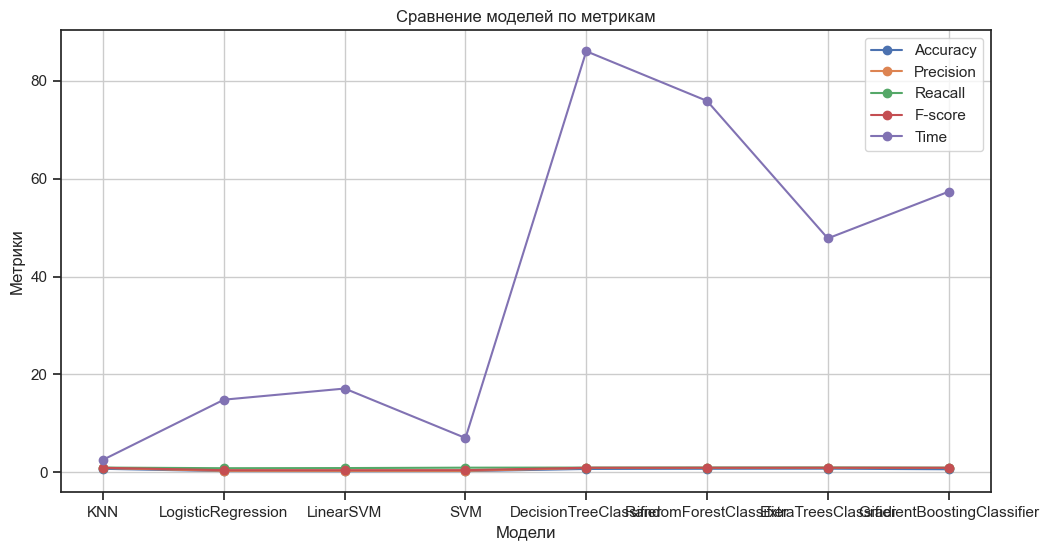

In [785]:
# Строим график
plt.figure(figsize=(12, 6))
for metric in metrics:
    plt.plot(models, df.loc[:, metric], marker='o', label=metric)
plt.xlabel('Модели')
plt.ylabel('Метрики')
plt.title('Сравнение моделей по метрикам')
plt.legend()
plt.grid(True)
plt.show()

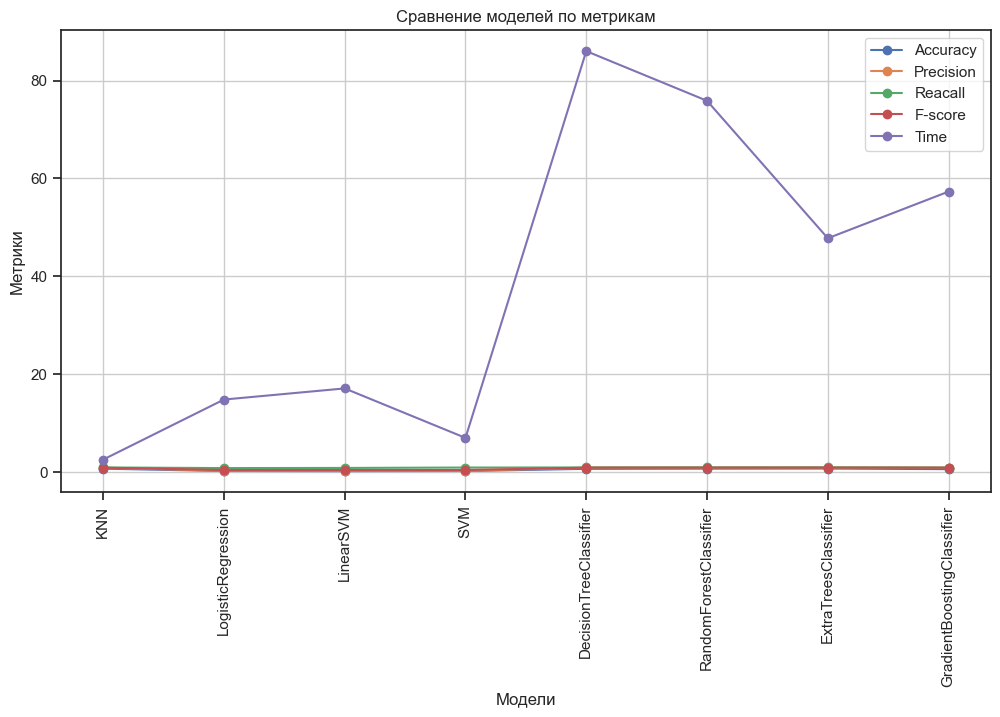

In [786]:
# Строим график
plt.figure(figsize=(12, 6))
for metric in metrics:
    plt.plot(models, df.loc[:, metric], marker='o', label=metric)
plt.xlabel('Модели')
plt.ylabel('Метрики')
plt.title('Сравнение моделей по метрикам')
plt.legend()
plt.grid(True)

# Переворачиваем подписи по оси x
plt.xticks(rotation=90)

plt.show()

In [791]:
df.iloc[6]


Accuracy      0.736842
Precision     0.892396
Reacall       0.974922
F-score       0.931835
Time         47.789045
Name: ExtraTreesClassifier, dtype: float64